In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from torchinfo import summary

import loss_landscapes
import loss_landscapes.metrics

from loss_landscapes.model_interface.model_wrapper import ModelWrapper
import torch
import torch.nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

import os

In [2]:
# training hyperparameters
IN_DIM = 28 * 28
OUT_DIM = 10
LR = 10 ** -2
BATCH_SIZE = 512
EPOCHS = 25
# contour plot resolution
STEPS = 40

In [3]:
class MLPSmall(torch.nn.Module):
    """ Fully connected feed-forward neural network with one hidden layer. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 32)
        self.linear_2 = torch.nn.Linear(32, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.softmax(self.linear_2(h), dim=1)


class Flatten(object):
    """ Transforms a PIL image to a flat numpy array. """
    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten()    
    

def train(model, optimizer, criterion, train_loader, epochs):
    """ Trains the given model with the given optimizer, loss function, etc. """
    model.train()
    # train model
    for _ in tqdm(range(epochs), 'Training'):
        for count, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, y = batch

            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    model.eval()

In [4]:
# download MNIST and setup data loaders
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=Flatten())
#train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=False)

# For labels 0-4
labels = [0,1,2,3,4]
indices = [idx for idx, target in enumerate(mnist_train.targets) if target in labels]
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist_train, indices),
                                         batch_size=BATCH_SIZE)

# define model
model = MLPSmall(IN_DIM, OUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
train(model, optimizer, criterion, train_loader, EPOCHS)

model_final = copy.deepcopy(model)

Training: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


In [6]:
# Get all the model parameters
params = [p for p in model.parameters()]

# Calculate the standard deviation of all parameters
wt_std = torch.std(torch.cat([p.view(-1) for p in params]))

DISTANCE=10*wt_std.detach().numpy()

print(DISTANCE)

2.187090814113617


In [7]:
perturbation_range = np.round(np.linspace(-0.5*DISTANCE, 0.5*DISTANCE, 8), 3)

In [8]:
def plot_loss_contours(loss_data, steps, distance, save_fig=False, save_fig_name='loss_contours.png'):
    perturbation_range = np.round(np.linspace(-0.5*distance, 0.5*distance, 8), 3)

    save_fig_name = os.path.join(save_fig_name)
    fig, ax = plt.subplots(1, 1)
    plt.contourf(np.log(loss_data), levels=50)
    ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
    ax.axis('square')
    ax.scatter((steps-1)/2., (steps-1)/2., 20, 'r', '*')
    ax.set_xticks(np.linspace(0, steps, 8, endpoint=True))
    ax.set_xticklabels(perturbation_range)
    ax.set_yticks(np.linspace(0, steps, 8, endpoint=True))
    ax.set_yticklabels(perturbation_range)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    plt.colorbar()
    plt.show()

    if save_fig:
        fig.savefig(save_fig_name, transparent=True, dpi=300)

In [15]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=Flatten())
#test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

# For labels 5
labels = [8]
indices = [idx for idx, target in enumerate(mnist_test.targets) if target in labels]
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist_test, indices),
                                         batch_size=BATCH_SIZE)

In [16]:
for batch_idx, (data, target) in enumerate(test_loader):    
    metric = loss_landscapes.metrics.Loss(criterion, data, target)
    loss_data_fin = loss_landscapes.random_plane(model_final, metric, distance=DISTANCE, 
                                                 steps=STEPS, normalization='filter', deepcopy_model=True)


In [17]:
loss_data_fin /= len(test_loader)

/tmp/ipykernel_2155/3096565923.py:9: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.scatter((steps-1)/2., (steps-1)/2., 20, 'r', '*')


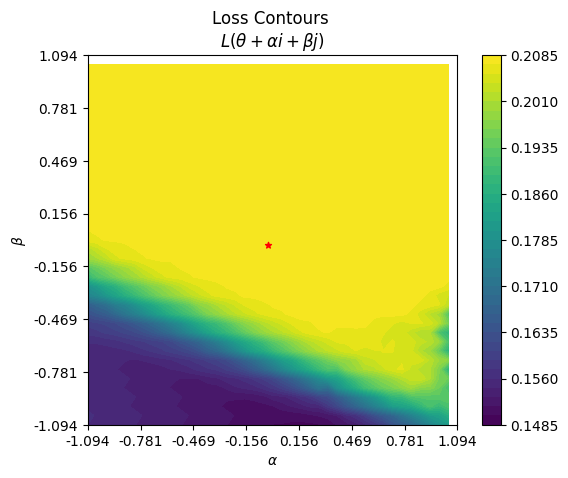

In [18]:
plot_loss_contours(loss_data=loss_data_fin, steps=STEPS, distance=DISTANCE, save_fig=True)

/tmp/ipykernel_2155/3096565923.py:9: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.scatter((steps-1)/2., (steps-1)/2., 20, 'r', '*')


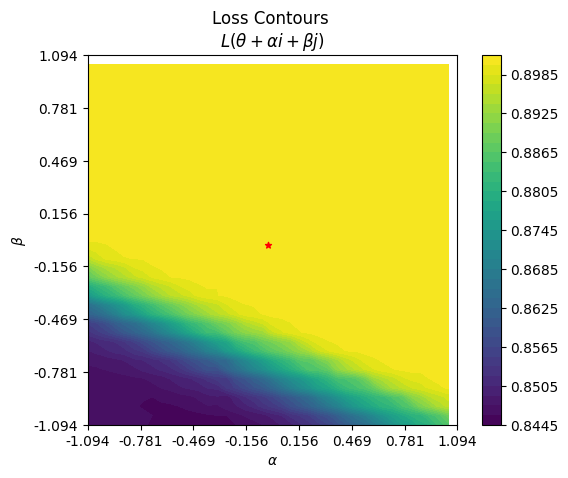

In [25]:
x, y = iter(test_loader).__next__()

metric = loss_landscapes.metrics.Loss(criterion, x, y)

loss_data_fin = loss_landscapes.random_plane(model_final, metric, distance=DISTANCE, steps=STEPS, normalization='filter', deepcopy_model=True)

plot_loss_contours(loss_data=loss_data_fin, steps=STEPS, distance=DISTANCE, save_fig=True)

In [20]:
perturbation_range

array([-1.094, -0.781, -0.469, -0.156,  0.156,  0.469,  0.781,  1.094])